# BAST Multitask Training Notebook

This notebook recreates the training loop from `train_multitask.py` with all configuration set directly here.


In [1]:
# Import necessary modules
from network.BAST import BAST_Variant, AngularLossWithCartesianCoordinate, MixWithCartesianCoordinate
from data_loading import SpectrogramDataset
import argparse  # Not used but keeping for compatibility
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from datetime import datetime

In [2]:
# Configuration - Set all parameters directly here

# Dataset configuration
CSV_PATH = 'tensor_metadata.csv'  # Replace with your CSV file path

# Model architecture parameters
SPECTROGRAM_SIZE = [64, 18]  # [frequency_bins, time_frames] - cropped to 100ms
PATCH_SIZE = 16
PATCH_OVERLAP = 10
NUM_OUTPUT = 2  # Output dimension for localization
EMBEDDING_DIM = 1024
TRANSFORMER_DEPTH = 3
TRANSFORMER_HEADS = 16
TRANSFORMER_MLP_DIM = 1024
TRANSFORMER_DIM_HEAD = 64
INPUT_CHANNEL = 1  # Single channel per ear
DROPOUT = 0.2
EMB_DROPOUT = 0.2
TRANSFORMER_POOL = 'conv'

# Training hyperparameters
EPOCHS = 20
BATCH_SIZE = 500
LEARNING_RATE = 0.0001
TEST_SPLIT = 0.1  # Test split ratio (10% of total dataset)
VAL_SPLIT = 0.2   # Validation split ratio (20% of remaining 90% after test split)
SEED = 42

# Loss weights for multitask learning
CLS_WEIGHT = 1.0      # Classification loss weight
ELEV_WEIGHT = 0.1     # Elevation regression loss weight

# Model configuration
BACKBONE = 'vanilla'  # Transformer variant: 'vanilla'
BINAURAL_INTEGRATION = 'SUB'  # 'SUB', 'ADD', 'CONCAT'
SHARE_WEIGHTS = False  # Share weights between left/right branches
LOSS_TYPE = 'MIX'     # Localization loss: 'MSE', 'AD', 'MIX'

# GPU configuration
GPU_LIST = [0] if torch.cuda.is_available() else []  # Use GPU 0 if available

# Directory configuration
MODEL_SAVE_DIR = './output/models/'
MODEL_NAME = 'BAST'

# DataLoader configuration
NUM_WORKERS = 4

In [3]:
# Helper function to get localization criterion
def get_localization_criterion(name: str):
    if name == 'MSE':
        return nn.MSELoss()
    if name == 'AD':
        return AngularLossWithCartesianCoordinate()
    if name == 'MIX':
        return MixWithCartesianCoordinate()
    raise ValueError('Unknown localization loss')

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create output directory
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [4]:
# Load and prepare dataset
print(f"[{datetime.now()}] Loading dataset from {CSV_PATH} ...")
dataset = SpectrogramDataset(CSV_PATH)
num_classes = len(dataset.class_to_index)
print(f"[{datetime.now()}] Samples: {len(dataset)} | Classes: {num_classes}")

# Create train/test/validation split
test_size = int(len(dataset) * TEST_SPLIT)
remaining_size = len(dataset) - test_size

# First split off test set
remaining_ds, test_ds = random_split(dataset, [remaining_size, test_size], generator=torch.Generator().manual_seed(SEED))

# Then split remaining into train and validation
val_size = int(remaining_size * VAL_SPLIT)
train_size = remaining_size - val_size
train_ds, val_ds = random_split(remaining_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED+1))

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")

[2025-08-24 21:29:28.278914] Loading dataset from tensor_metadata.csv ...
[2025-08-24 21:29:28.283149] Samples: 3190 | Classes: 3
Train set: 2297 samples
Validation set: 574 samples
Test set: 319 samples


In [5]:
# Build the model
print(f"[{datetime.now()}] Building model ...")

net = BAST_Variant(
    image_size=SPECTROGRAM_SIZE,
    patch_size=PATCH_SIZE,
    patch_overlap=PATCH_OVERLAP,
    num_classes=NUM_OUTPUT,
    dim=EMBEDDING_DIM,
    depth=TRANSFORMER_DEPTH,
    heads=TRANSFORMER_HEADS,
    mlp_dim=TRANSFORMER_MLP_DIM,
    pool=TRANSFORMER_POOL,
    channels=INPUT_CHANNEL,
    dim_head=TRANSFORMER_DIM_HEAD,
    dropout=DROPOUT,
    emb_dropout=EMB_DROPOUT,
    binaural_integration=BINAURAL_INTEGRATION,
    share_params=SHARE_WEIGHTS,
    transformer_variant=BACKBONE,
    classify_sound=True,
    num_classes_cls=num_classes,
    regress_elevation=True,
)

# Setup device and move model to device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
if use_cuda and GPU_LIST:
    net = nn.DataParallel(net, device_ids=GPU_LIST).to(device)
else:
    net = net.to(device)

print(f"Model built successfully. Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in net.parameters())}")

[2025-08-24 21:29:29.365599] Building model ...
Model built successfully. Using device: cuda
Model parameters: 56983577


In [6]:
# Setup optimizer and loss functions
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0.0)
criterion_loc = get_localization_criterion(LOSS_TYPE)

if num_classes > 1:
    criterion_cls = nn.CrossEntropyLoss()
else:
    criterion_cls = nn.BCEWithLogitsLoss()
    
criterion_elev = nn.MSELoss()

# Create model save name
model_save_name = f"{MODEL_NAME}_{BINAURAL_INTEGRATION}_{LOSS_TYPE}_MT_{'SP' if SHARE_WEIGHTS else 'NSP'}_{BACKBONE}"

print(f"Model will be saved as: {model_save_name}")
print(f"Training for {EPOCHS} epochs with batch size {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Loss weights - Classification: {CLS_WEIGHT}, Elevation: {ELEV_WEIGHT}")

Model will be saved as: BAST_SUB_MIX_MT_NSP_vanilla
Training for 20 epochs with batch size 500
Learning rate: 0.0001
Loss weights - Classification: 1.0, Elevation: 0.1


In [ ]:
# Training loop
print(f"[{datetime.now()}] Start training ...")

best_val = float('inf')
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training phase
    net.train()
    running = 0.0
    n_train = 0
    
    for batch in train_loader:
        specs, loc_xy, cls_idx, az_el_deg = batch
        specs = specs.to(device, non_blocking=True)
        loc_xy = loc_xy.to(device, non_blocking=True)
        cls_idx = cls_idx.to(device, non_blocking=True).squeeze(1)
        az_el_deg = az_el_deg.to(device, non_blocking=True)

        outputs = net(specs)
        # outputs: (loc_out, cls_out, elev_out)
        loc_out = outputs[0]
        cls_out = outputs[1]
        elev_out = outputs[2]

        # Calculate losses
        loss_loc = criterion_loc(loc_out, loc_xy)
        
        if num_classes > 1:
            loss_cls = criterion_cls(cls_out, cls_idx)
        else:
            # BCE expects float targets with shape [B,1]
            target_bce = cls_idx.float().unsqueeze(1)
            loss_cls = criterion_cls(cls_out, target_bce)
        
        # elevation is a single scalar in degrees
        loss_elev = criterion_elev(elev_out.squeeze(1), az_el_deg[:, 1])

        # Combined loss
        loss = loss_loc + CLS_WEIGHT * loss_cls + ELEV_WEIGHT * loss_elev

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bsz = specs.size(0)
        running += loss.item() * bsz
        n_train += bsz

    avg_tr = running / max(1, n_train)
    train_losses.append(avg_tr)

    # Validation phase
    net.eval()
    running_val = 0.0
    n_val = 0
    
    with torch.no_grad():
        for batch in val_loader:
            specs, loc_xy, cls_idx, az_el_deg = batch
            specs = specs.to(device, non_blocking=True)
            loc_xy = loc_xy.to(device, non_blocking=True)
            cls_idx = cls_idx.to(device, non_blocking=True).squeeze(1)
            az_el_deg = az_el_deg.to(device, non_blocking=True)

            outputs = net(specs)
            loc_out = outputs[0]
            cls_out = outputs[1]
            elev_out = outputs[2]

            loss_loc = criterion_loc(loc_out, loc_xy)
            
            if num_classes > 1:
                loss_cls = criterion_cls(cls_out, cls_idx)
            else:
                target_bce = cls_idx.float().unsqueeze(1)
                loss_cls = criterion_cls(cls_out, target_bce)
            
            loss_elev = criterion_elev(elev_out.squeeze(1), az_el_deg[:, 1])

            loss = loss_loc + CLS_WEIGHT * loss_cls + ELEV_WEIGHT * loss_elev
            bsz = specs.size(0)
            running_val += loss.item() * bsz
            n_val += bsz

    avg_val = running_val / max(1, n_val)
    val_losses.append(avg_val)

    print(f"[{datetime.now()}] Epoch {epoch+1:03d}/{EPOCHS} | train {avg_tr:.4f} | val {avg_val:.4f}")

    # Save best model
    if avg_val < best_val:
        best_val = avg_val
        state = net.module.state_dict() if isinstance(net, nn.DataParallel) else net.state_dict()
        torch.save({
            'epoch': epoch,
            'state_dict': state,
            'best_loss': best_val,
            'log': {'training': train_losses, 'validation': val_losses},
            'conf': {
                'image_size': SPECTROGRAM_SIZE,
                'patch_size': PATCH_SIZE,
                'patch_overlap': PATCH_OVERLAP,
                'num_classes': NUM_OUTPUT,
            }
        }, os.path.join(MODEL_SAVE_DIR, model_save_name + '_best.pkl'))
        print(f"  -> Saved best model with validation loss: {best_val:.4f}")

    # Save last model
    state = net.module.state_dict() if isinstance(net, nn.DataParallel) else net.state_dict()
    torch.save({
        'epoch': epoch,
        'state_dict': state,
        'best_loss': best_val,
        'log': {'training': train_losses, 'validation': val_losses},
    }, os.path.join(MODEL_SAVE_DIR, model_save_name + '_last.pkl'))

print(f"[{datetime.now()}] Training completed!")
# Evaluate on test set
print(f"[{datetime.now()}] Evaluating on test set...")
net.eval()
test_running = 0.0
n_test = 0

test_correct = 0
test_total = 0
az_errors = []
el_errors = []

with torch.no_grad():
    for batch in test_loader:
        specs, loc_xy, cls_idx, az_el_deg = batch
        specs = specs.to(device, non_blocking=True)
        loc_xy = loc_xy.to(device, non_blocking=True)
        cls_idx = cls_idx.to(device, non_blocking=True).squeeze(1)
        az_el_deg = az_el_deg.to(device, non_blocking=True)

        outputs = net(specs)
        loc_out = outputs[0]
        cls_out = outputs[1]
        elev_out = outputs[2]

        loss_loc = criterion_loc(loc_out, loc_xy)
        
        if num_classes > 1:
            loss_cls = criterion_cls(cls_out, cls_idx)
            # Calculate classification accuracy
            _, predicted = torch.max(cls_out, 1)
            test_correct += (predicted == cls_idx).sum().item()
        else:
            target_bce = cls_idx.float().unsqueeze(1)
            loss_cls = criterion_cls(cls_out, target_bce)
            # Calculate classification accuracy for binary case
            predicted = (cls_out > 0.5).float().squeeze(1)
            test_correct += (predicted == cls_idx.float()).sum().item()
        
        test_total += cls_idx.size(0)
        
        loss_elev = criterion_elev(elev_out.squeeze(1), az_el_deg[:, 1])

        # Calculate azimuth error (assuming loc_out represents azimuth in some form)
        # Convert xy coordinates back to azimuth for error calculation
        pred_az = torch.atan2(loc_out[:, 1], loc_out[:, 0]) * 180 / torch.pi
        true_az = az_el_deg[:, 0]
        az_error = torch.abs(pred_az - true_az)
        # Handle angle wrapping (e.g., 359° vs 1°)
        az_error = torch.min(az_error, 360 - az_error)
        az_errors.extend(az_error.cpu().numpy())
        
        # Calculate elevation error
        pred_el = elev_out.squeeze(1)
        true_el = az_el_deg[:, 1]
        el_error = torch.abs(pred_el - true_el)
        el_errors.extend(el_error.cpu().numpy())

        loss = loss_loc + CLS_WEIGHT * loss_cls + ELEV_WEIGHT * loss_elev
        bsz = specs.size(0)
        test_running += loss.item() * bsz
        n_test += bsz

avg_test = test_running / max(1, n_test)

print(f"[{datetime.now()}] Training completed!")
print(f"Best validation loss: {best_val:.4f}")
print(f"Test loss: {avg_test:.4f}")
print(f"Models saved in: {MODEL_SAVE_DIR}")

[2025-08-24 21:29:30.777986] Start training ...
[2025-08-24 21:29:35.430042] Epoch 001/20 | train 284.4948 | val 266.3770
  -> Saved best model with validation loss: 266.3770
[2025-08-24 21:29:38.665830] Epoch 002/20 | train 275.7739 | val 265.5641
  -> Saved best model with validation loss: 265.5641
[2025-08-24 21:29:41.848357] Epoch 003/20 | train 270.9965 | val 262.4206
  -> Saved best model with validation loss: 262.4206
[2025-08-24 21:29:45.026098] Epoch 004/20 | train 266.1327 | val 257.1457
  -> Saved best model with validation loss: 257.1457
[2025-08-24 21:29:48.251291] Epoch 005/20 | train 260.6983 | val 252.3328
  -> Saved best model with validation loss: 252.3328
[2025-08-24 21:29:51.424544] Epoch 006/20 | train 253.9232 | val 246.2649
  -> Saved best model with validation loss: 246.2649
[2025-08-24 21:29:54.670765] Epoch 007/20 | train 246.2247 | val 241.2047
  -> Saved best model with validation loss: 241.2047
[2025-08-24 21:29:57.911234] Epoch 008/20 | train 238.0358 | va

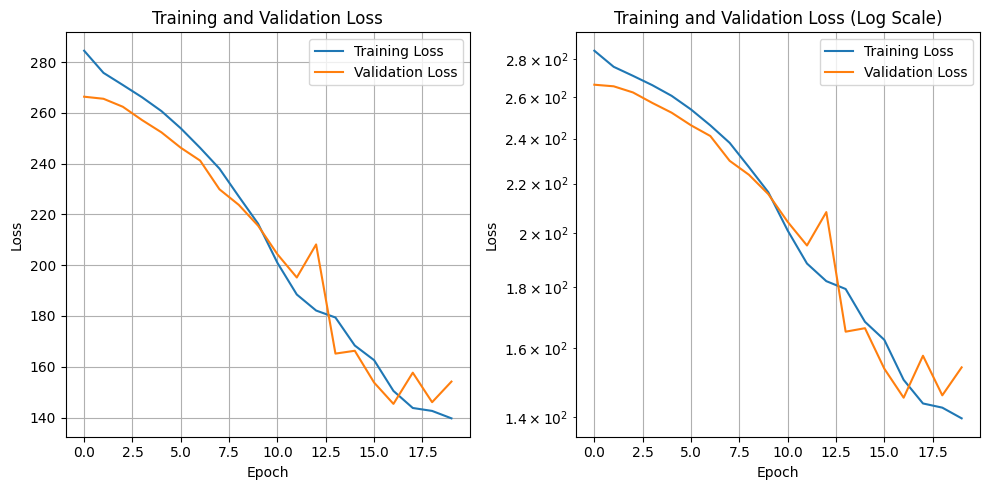

Final training loss: 139.6728
Final validation loss: 154.1527


In [8]:
# Plot training curves (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

In [13]:

test_correct = 0
test_total = 0
az_errors = []
el_errors = []

with torch.no_grad():
    for batch in test_loader:
        specs, loc_xy, cls_idx, az_el_deg = batch
        specs = specs.to(device, non_blocking=True)
        loc_xy = loc_xy.to(device, non_blocking=True)
        cls_idx = cls_idx.to(device, non_blocking=True).squeeze(1)
        az_el_deg = az_el_deg.to(device, non_blocking=True)

        outputs = net(specs)
        loc_out = outputs[0]
        cls_out = outputs[1]
        elev_out = outputs[2]

        loss_loc = criterion_loc(loc_out, loc_xy)
        
        if num_classes > 1:
            loss_cls = criterion_cls(cls_out, cls_idx)
            # Calculate classification accuracy
            _, predicted = torch.max(cls_out, 1)
            test_correct += (predicted == cls_idx).sum().item()
        else:
            target_bce = cls_idx.float().unsqueeze(1)
            loss_cls = criterion_cls(cls_out, target_bce)
            # Calculate classification accuracy for binary case
            predicted = (cls_out > 0.7).float().squeeze(1)
            test_correct += (predicted == cls_idx.float()).sum().item()
        
        test_total += cls_idx.size(0)
        
        loss_elev = criterion_elev(elev_out.squeeze(1), az_el_deg[:, 1])

        # Calculate azimuth error (assuming loc_out represents azimuth in some form)
        # Convert xy coordinates back to azimuth for error calculation
        pred_az = torch.atan2(loc_out[:, 1], loc_out[:, 0]) * 180 / torch.pi
        true_az = az_el_deg[:, 0]
        az_error = torch.abs(pred_az - true_az)
        # Handle angle wrapping (e.g., 359° vs 1°)
        az_error = torch.min(az_error, 360 - az_error)
        az_errors.extend(az_error.cpu().numpy())
        
        # Calculate elevation error
        pred_el = elev_out.squeeze(1)
        true_el = az_el_deg[:, 1]
        el_error = torch.abs(pred_el - true_el)
        el_errors.extend(el_error.cpu().numpy())

        loss = loss_loc + CLS_WEIGHT * loss_cls + ELEV_WEIGHT * loss_elev
        bsz = specs.size(0)
        test_running += loss.item() * bsz
        n_test += bsz

avg_test = test_running / max(1, n_test)

print(f"[{datetime.now()}] Training completed!")
print(f"Best validation loss: {best_val:.4f}")
print(f"Test loss: {avg_test:.4f}")
print(f"Test accuracy: {test_correct / test_total:.4f}")
print(f"Average azimuth error: {np.mean(az_errors):.2f}°")
print(f"Average elevation error: {np.mean(el_errors):.2f}°")
print(f"Models saved in: {MODEL_SAVE_DIR}")

[2025-08-24 21:37:53.882753] Training completed!
Best validation loss: 145.3658
Test loss: 147.1022
Test accuracy: 0.6771
Average azimuth error: 35.92°
Average elevation error: 31.29°
Models saved in: ./output/models/
